# I wrote my report in a seperate file to preserve the results from Kmeans. Look for the PDF named Mini-Project

Derivative of Vectors
http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf

Residual Sum of Squares
https://mcneela.github.io/machine_learning/2017/07/07/Linear-Regression.html

Minimum of Residual Sum of Squares
http://users.stat.umn.edu/~helwig/notes/mvlr-Notes.pdf

Binary classification can be more akin to viewing it as linear regression then looking at the sign. So we define 
$$RSS(B, \alpha) = \sum_{i = 1}^{N} (y_{i} - \overline{f_{i}})^{2}$$ where $ \overline{f_{i}} = B^{T}x_{i} + \alpha$. If we look at the general example of $B^{T}x = B_{1}x_{1} + B_{2}x_{2} + \ldots + B_{n}x_{n} + \alpha$, we can define $c = [B_{1}, B_{2}, \ldots, B_{n}, \alpha]$  and define $d = [x_{1}, x_{2}, x_{3}, \ldots, x_{n}, 1]$ we get that $\overline{f_{i}} = c^{T}d$. So, 

$$RSS(c) = \sum_{i = 1}^{N} (y_{i} - c^{T}d)^{2}$$

and from the online resources we can calculate the min of c as $$c = (d^{T}d)^{-1} d^{T}y$$

In [5]:
import seaborn as sns;
import pandas as pd
import numpy as np

class Binary_Classifier:
    """Binary Classifier
    
    Binary Classifier using least square method.
    
    Atributes:
        data: Training Dataset, doesn't explicitly use but saved for child classes
        labels: Labels doesn't use after storing
        intercepts: Intercept values used in prediction
        parameters: Parameter values used in prediction
        
    Methods:
        predict:
        
            Predicts the binary outcome based on given input
            
            Arguments:
                test: np.array of side m x n

                
                
        linear_regression:
            Linear Regression based on parameter values. Calculated by X @ B + a
            
            Arguments:
                test: testing dataset
                
                
        least_square_classifier_constants:
            Creates the parameters for the provided training datasets
            
            Arguments:
                Y: labels for dataset
                X: inputs for dataset
                
            Raise:
                Raises an error if Y rows does not match X rows
                
                
    Static Methods:
        Arguments:
                    actual: the actual value
                    predicted: the predicted values
        RMSE:
            Calculates the RMSE
            
        errorRate:
            Calculates the number of misses / total
            
        confusion_matrix:
            Creates the confusion matrix
            
            
    
    """
    def __init__(self, training: np.array , labels:np.array):
        """Inits Binary_Classifier object and generates the necessary constants
        
        Arguments:
            training: Training dataset
            labels: Label dataset
        
        """
        (self.intercepts, self.parameters) = self.least_square_classifier_constants(labels, training)
        self.data = training
        self.labels = labels
    
    def predict(self, test:np.array):

        return np.sign(self.linear_regression(test))
    
    def linear_regression(self, test: np.array):
        if(len(test.shape) == 1):
            test = test.reshape(test.shape[0], -1)
        return test @ self.parameters + self.intercepts
        
    def least_square_classifier_constants(self, Y:np.array, X:np.array, single=False):
        if(len(Y.shape) == 1):
            Y = Y.reshape(Y.shape[0], -1)

        if(len(X.shape) == 1):
            X = X.reshape(X.shape[0], -1)

        if(Y.shape[0] != X.shape[0]):
            print(Y.shape, X.shape)
            raise "The shapes do not match"
        else:
            ones = np.ones([len(X), 1])
            d = np.hstack([ones, X])
            c = np.linalg.pinv(d.T @ d) @ d.T @ Y
            if single:
                return c
            else:
                return (c[0], c[1:])
            
        
    @staticmethod
    def RMSE(predict: np.array, actual: np.array):
        return np.sqrt(np.mean((predict-actual)**2))

    @staticmethod
    def errorRate(predicted: np.array, actual: np.array):
        
        predicted = predicted.flatten()
        actual = actual.flatten()
        if predicted.shape != actual.shape:
            raise "Prediction and True values are not of same size"
        return np.count_nonzero(predicted != actual) / len(predicted)

    @staticmethod
    def confusion_matrix(predicted:np.array, actual:np.array):
        
        u = np.unique(actual)
        matrix = np.zeros((len(u) + 1, len(u)  + 1))
        predicted = predicted.flatten()
        actual = actual.flatten()
        if predicted.shape != actual.shape:
            raise "Prediction and True values are not of same size"
        for i, j in zip(actual, predicted):
            matrix[i, j] += 1
            matrix[-1, -1] += 1
            matrix[i, -1] += 1
            matrix[-1, j] += 1
        matrix = matrix.astype(int)

        ova_ax = sns.heatmap(matrix[:-1, :-1], annot=True, fmt="d")
        ova_ax.set(xlabel='Predicted Values', ylabel='True Values')
        ova_df = pd.DataFrame(matrix)
        return ova_df 


In [2]:
class One_vs_All(Binary_Classifier):
    """One vs All class that inherits from Binary Classifier
    
    Methods:
        predict:
            preditcts the argmax of the output of linear regression
            
            Arguments:
                test: Testing dataset
                
        separate_classes:
            seperates n classes into nxn matrix where each column corresponds to a specific class
            
            Arguments:
                Y: class to be separated
    """
    def predict(self, test: np.array):
        return np.argmax(self.linear_regression(test), axis=1)
    
    def __init__(self, training:np.array, labels:np.array):
        super().__init__(training, self.separate_classes(labels))
    
    def separate_classes(self, Y: np.array):
        uni = np.unique(Y)
        s = np.where(np.zeros((Y.shape[0], len(uni))) == 0, -1, 0)
        for i, k in enumerate(Y):
            s[i, k] = 1
        return s

In [3]:
class One_vs_One(Binary_Classifier):
    """One vs One class that inherits from Binary_Classifier
    
    Methods:
        least_square_classifier_constants:
            Rewritten to create parameters for each different class
            
            Arguments:
                Y: Training Labels
                X: Training inputs
        
        predict:
            Predicts the output for each class and stores the number of "votes" in an occurence matrix
            
            Arguments:
                test: Testing dataset
    """
    def least_square_classifier_constants(self, Y: np.array, X:np.array):
        classes = np.unique(Y)
        intercepts = []
        parameters = []
        for index, value in enumerate(classes):
            for jndex, jalue in enumerate(classes[index + 1:], index + 1):
                # Isolate classes that are being compared
                mask = np.logical_or(Y == value, Y == jalue)
                temp = np.where(Y[mask] == value, 1, -1)
                
                #create intercept and parameters and store them to be packaged off all at once
                (a, b) = super().least_square_classifier_constants(temp, X[mask])
                intercepts.append(a)
                parameters.append(b)
        return (np.array(intercepts), np.array(parameters))
    
    def predict(self, test: np.array):
        count = 0
        unique_list = np.unique(self.labels)
        num_classes = unique_list.shape[0]
        occurence_matrix = np.zeros((test.shape[0], num_classes))
        
        print(self.intercepts.shape)
        print(self.parameters.shape)

        for index, value in enumerate(unique_list):
            for jndex, jalue in enumerate(unique_list[index + 1:], index + 1):
                
                #compares the test dataset with each boolean class
                a = self.intercepts[count]
                b = self.parameters[count]
                
                ova = np.sign(test @ b + a).flatten()

                # create a mask of where it is 1 or -1 and add them to the occurence matrix
                mask1 = np.where(ova == 1, 1, 0)
                mask2 = np.where(ova == 1, 0, 1)

                occurence_matrix[:, index] += mask1
                occurence_matrix[:, jndex] += mask2
                count += 1

        return np.argmax(occurence_matrix, axis = 1)

In [4]:
from mlxtend.data import loadlocal_mnist
import platform
import time

X_train, y_train = loadlocal_mnist(
        images_path='train-images.idx3-ubyte', 
        labels_path='train-labels.idx1-ubyte')

X_test, y_test = loadlocal_mnist(
                    images_path="t10k-images.idx3-ubyte",
                    labels_path="t10k-labels.idx1-ubyte")

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [5]:
# one vs all mnist
start_time = time.time()
ova_mnist = One_vs_All(X_train, y_train)
print("OVA Constants Runtime=", time.time() - start_time)

start_time = time.time()
ova_prediction = ova_mnist.predict(X_test)
print("OVA Prediction Runtime=", time.time() - start_time)
print("Error Rate=", Binary_Classifier.errorRate(ova_prediction, y_test))

OVA Constants Runtime= 1.415585994720459
OVA Prediction Runtime= 0.0471196174621582
Error Rate= 0.1397


,0,1,2,3,4,5,6,7,8,9,10
0,944,0,1,2,2,7,14,2,7,1,980
1,0,1107,2,2,3,1,5,1,14,0,1135
2,18,54,813,26,15,0,42,22,37,5,1032
3,4,17,23,880,5,17,9,21,22,12,1010
4,0,22,6,1,881,5,10,2,11,44,982
5,23,18,3,72,24,659,23,14,39,17,892
6,18,10,9,0,22,17,875,0,7,0,958
7,5,40,16,6,26,0,1,884,0,50,1028
8,14,46,11,30,27,40,15,12,759,20,974
9,15,11,2,17,80,1,1,77,4,801,1009


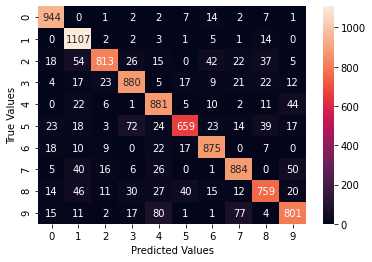

In [6]:
Binary_Classifier.confusion_matrix(ova_prediction, y_test)

In [7]:
# one vs one mnist
start_time = time.time()
ovo_mnist = One_vs_One(X_train, y_train)
print("OVO Constants Runtime=", time.time() - start_time)

start_time = time.time()
ovo_prediction = ovo_mnist.predict(X_test)
print("OVO Prediction Runtime=", time.time() - start_time)
print("Error Rate=", Binary_Classifier.errorRate(ovo_prediction, y_test))

OVO Constants Runtime= 24.440438747406006
(45, 1)
(45, 784, 1)
OVO Prediction Runtime= 1.5504968166351318
Error Rate= 0.0703


,0,1,2,3,4,5,6,7,8,9,10
0,961,0,1,1,0,6,8,3,0,0,980
1,0,1120,3,3,1,1,4,1,2,0,1135
2,9,18,936,12,10,5,10,10,22,0,1032
3,9,1,18,926,2,20,1,7,21,5,1010
4,2,4,6,1,931,1,7,4,3,23,982
5,7,5,3,30,8,800,17,2,15,5,892
6,6,5,12,0,5,19,908,1,2,0,958
7,1,16,17,3,11,1,0,955,1,23,1028
8,7,17,8,23,10,36,10,10,840,13,974
9,6,5,1,11,30,12,0,21,3,920,1009


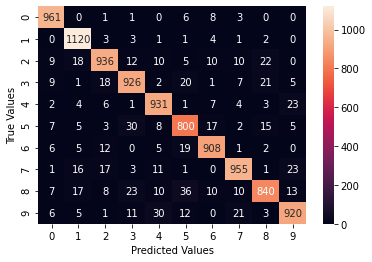

In [8]:
Binary_Classifier.confusion_matrix(ovo_prediction, y_test)

# (d) Training and Testing Multi-class classifiers on MNIST Dataset

(a): I implemented (i) one-verus-one in the functions "one_versus_one_constants" and "one_versus_one_classifier" and (ii) one_versus_all in the functions "least_square_one_versus_all_classifier"

(b) I calculated the error and the confusion matrix above

(c) One verus One had a lower error rate than One versus All, although both were pretty low. I am assuming they generalize pretty well since their respective error rates were low and the confusion matrix has low false positive and negative values. The easist digits to recognize are 1 and 0 whereas the hardest digits to recognize are 5 and 7. I suspect it's either because the dataset for those digits isn't as large as the other digits or because the algorithm might have a bias for numbers entered in first (ie. comparing 2 and 5 will mark 1 as 2 and -1 as 5)

(d) OvA is considerably faster than OvO when it comes to both calculating their parameters and their predictions. This is to be expected because my implementation is O(n^2) for OvO and is O(1) for OvA (assuming numpy operations run at constant time)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;
import numpy as np
import pandas as pd
import time
sns.set(rc={'figure.figsize':(11.7,8.27)})
import sys
import scipy

class K_means:
    """
    Initialized with the ability to do both random and nonrandom starts. It will create K data points as the K group
    representatives. All inputs were pre-normalized by taking the original data points and dividing by 255
    
    I tried to set my seed when selecting random points but for some reason it does not work if I do the same run twice.
    The seed changes each run to ensure that the centroids will be random each time. 
    
    Exits when the Jcluster value has not changed more than self.threshold. 
    
    """
    def __init__(self, X:np.array, labels: np.array, K: int, P: int,Threshold: float, random=True, random_seed=None):
        self.data = X
        self.labels = labels
        self.K = K
        self.iterations = P
        self.threshold = Threshold
        self.random = random
        self.random_seed = random_seed # seed will increase each run to produce different output
        
        self.minCluster = {
            "Cost": float('inf'),
            "Centroids": [],
            "Groups": [], 
            "ClusterHistory": []
        }
        
        self.maxCluster = {
            "Cost": float('-inf'),
            "Centroids": [],
            "Groups": [], 
            "ClusterHistory": []
        }
       
        
        
    def distance(self, A, B):
        A = A.flatten().astype(float)
        B = B.flatten().astype(float)
        return np.linalg.norm(A - B)
    
    def Kmeans(self, seed, continue_after_convergence=5):
        """
        Performs Kmeans and returns a list of grouped indices, the centroids, and the history of Jclust
        Will iterate until convergence occurs + continue_after_convergence steps
        """
        np.random.seed(self.random_seed + seed)
            
        # create random centroids
        randoms = np.random.choice(self.data.shape[0], self.K, replace=False)
        current_centroids = self.data[randoms] if self.random else self.data[range(K)]

        Jcluster_history = []
        count = 0
        start = 0

        start_time = time.time()
        while True:

            new_groups = [[] for k in range(self.K)]

            # calculate all possible distances. Leaving my previous code down below as scipy's implementation is much faster
            # taken from 
            # https://stackoverflow.com/questions/6430091/efficient-distance-calculation-between-n-points-and-a-reference-in-numpy-scipy
            distances = scipy.spatial.distance.cdist(self.data,current_centroids)

            # find min index 
            min_d = np.argmin(distances, axis = 1)
            for index, row in enumerate(self.data):
#                     d = [self.distance(row, centroid) for centroid in current_centroids]
#                     print(d)
#                     min_d = np.argmin(d)
                new_groups[min_d[index]].append(index)


            new_centroids = np.zeros((self.K, self.data.shape[1]))
            Jcosts = []
            distances = []
            for i, group in enumerate(new_groups):
                new_centroids[i] = np.mean(self.data[group], axis = 0)
                # distances = scipy.spatial.distance.cdist(self.data[group], new_centroids)
                # scipy is slower when doing it group by group so using old distance method
                distances.append([self.distance(row, new_centroids[i]) for row in self.data[group]])
                Jcosts.append(np.sum(np.square(distances[i])))





            costs = sum(Jcosts) / self.data.shape[0]
            percent_change = self.threshold + 1
            if count > 0:
                percent_change = abs((costs - Jcluster_history[-1]) / Jcluster_history[-1])


            Jcluster_history.append(costs)



            if percent_change < self.threshold:
                if start == 0:
                    print("Convergence has occurred. Iterating for {} more loops".format(continue_after_convergence))
                if start > continue_after_convergence:
                    for i, group in enumerate(new_groups):
                        sorted_groups = [ x for _, x in sorted(zip(distances[i], group))]
                        new_groups[i] = sorted_groups
                    self.verifySorted(new_groups, new_centroids)
                    print("Run: {} Iterations: {} Time: {}".format(seed + 1, count + 1, time.time() - start_time))
#                     if costs > self.maxCluster["Cost"]:
#                         self.maxCluster["Cost"] = costs
#                         self.maxCluster["Centroids"] = new_centroids
#                         self.maxCluster["Groups"] = new_groups
#                         self.maxCluster["ClusterHistory"] = Jcluster_history

#                     # check min
#                     if costs < self.minCluster["Cost"]:
#                         self.minCluster["Cost"] = costs
#                         self.minCluster["Centroids"] = new_centroids
#                         self.minCluster["Groups"] = new_groups
#                         self.minCluster["ClusterHistory"] = Jcluster_history
                    return new_centroids, new_groups, Jcluster_history

                    break
                else:
                    start += 1


            current_centroids = new_centroids.copy()
            count += 1
    

    
    def train(self, continue_after_convergence=5):
        """
        Runs 30 times keeping track of the centroids, groups, and Jclust history for each run. It only ever needs to store
        the min and max Jclust at any given moment to reduce in memory consumption. 
        """
        total_start = time.time()
        for o in range(0, self.iterations):
            centroids, groups, history = self.Kmeans(o, continue_after_convergence)
            costs = history[-1]
            if costs > self.maxCluster["Cost"]:
                self.maxCluster["Cost"] = costs
                self.maxCluster["Centroids"] = centroids
                self.maxCluster["Groups"] = groups
                self.maxCluster["ClusterHistory"] = history

            # check min
            if costs < self.minCluster["Cost"]:
                self.minCluster["Cost"] = costs
                self.minCluster["Centroids"] = centroids
                self.minCluster["Groups"] = groups
                self.minCluster["ClusterHistory"] = history
            
        print("Total Time: ", time.time() - total_start)
            
    def predict(self, X:np.array):
        """
        Prediction Algorithm that I tried to write but it was too inconsistent in how it labels centroids. Might revisit in the
        future.
        
        It guesses a centroid's value based on the closest data point
        https://stackoverflow.com/questions/8193563/predicting-values-with-k-means-clustering-algorithm
        """
        output = []
        for index, row in enumerate(X):
                distance = [self.distance(row, centroid) for centroid in self.minCluster["Centroids"]]
                min_d = np.argmin(distance)
                min_x_train_index = self.minCluster.get("Groups")[min_d][0]
                label = self.labels[min_x_train_index]
                output.append(label)
        return np.array(output)
            
    def verifySorted(self, groups, centroids):
        # finds the distances between each point and its centroid.
        # substacts each element in distances with python sorted and checks if there are any nonzero values
        for i, group in enumerate(groups):
            distances = np.array([self.distance(row, centroids[i]) for row in self.data[group]])
            if np.count_nonzero(distances - sorted(distances)) != 0 :
                raise "Not correctly Sorted based on distances"
            
    def plotJCluster(self, Min=True):
        c = self.minCluster["ClusterHistory"] if Min else self.maxCluster["ClusterHistory"]
        df1 = pd.DataFrame({
            "Iterations": range(1, len(c) + 1),
            "J Cluster": c
        })
        
        plt.title("J Clusters over iterations for K={} P={} {}".format(self.K, self.iterations, "Min" if Min else "Max"))
        s1 = sns.lineplot(data = df1, x="Iterations", y="J Cluster")



    def visualizeCentroids(self, rows: int, columns: int, Min=True):
        # https://stackoverflow.com/questions/37228371/visualize-mnist-dataset-using-opencv-or-matplotlib-pyplot
        # based plotting on this stack overflow question
        
        f, ax = plt.subplots(rows, columns)
        f.suptitle("Visualization of Centroids for K={} P={} {}".format(self.K, self.iterations, "Min" if Min else "Max"))
        c = self.minCluster["Centroids"] if Min else self.maxCluster["Centroids"]
        for index, values in enumerate(c):
            first_image = np.array(values * 255, dtype='uint8')
            pixels = first_image.reshape((28, 28))

            ax[int(index / columns), int(index % columns)].imshow(pixels, cmap="gray")
            ax[int(index / columns), int(index % columns)].axes.xaxis.set_visible(False)
            ax[int(index / columns), int(index % columns)].axes.yaxis.set_visible(False)
            
    def visualizeClosestToCentroids(self, Min=True):
        """
        Plots the min or max Jcluster history values
        """
        f, axes = plt.subplots(nrows = self.K, ncols=11, figsize=(15, 15))
        plt.xticks([])
        plt.yticks([])
        f.suptitle("Visualization of Centroids and Their 10 closests points for K={} P={} {}".format(self.K, self.iterations, "Min" if Min else "Max"), fontsize=16)
        
        c = self.minCluster if Min else self.maxCluster
        
        for index in range(self.K):
            centroid = c["Centroids"][index]
            first_image = np.array(centroid * 255, dtype="uint8")
            first_pixels = first_image.reshape((28, 28))
            axes[index, 0].imshow(first_pixels, cmap="gray")
            axes[index, 0].axes.xaxis.set_visible(False)
            axes[index, 0].axes.yaxis.set_visible(False)
            for i, closest_index in enumerate(c["Groups"][index][:10]):
                first_image = np.array(self.data[closest_index] * 255, dtype="uint8")
                first_pixels = first_image.reshape((28, 28))
                axes[index, i + 1].imshow(first_pixels, cmap="gray")
                axes[index, i + 1].title.set_text(self.labels[closest_index])
                axes[index, i + 1].axes.xaxis.set_visible(False)
                axes[index, i + 1].axes.yaxis.set_visible(False)
                
        f.subplots_adjust(hspace=1)
        plt.show()

In [2]:
from mlxtend.data import loadlocal_mnist
import platform
import time

X_train, y_train = loadlocal_mnist(
        images_path='train-images.idx3-ubyte', 
        labels_path='train-labels.idx1-ubyte')

X_test, y_test = loadlocal_mnist(
                    images_path="t10k-images.idx3-ubyte",
                    labels_path="t10k-labels.idx1-ubyte")

X_train.shape, y_train.shape, X_test.shape, y_test.shape
X_train = X_train/255
X_test = X_test/255

In [3]:
m_k = K_means(X_train, y_train, 20, 30, 0.0001, random_seed = 42)
m_k.train()

Convergence has occurred. Iterating for 5 more loops
Run: 1 Iterations: 46 Time: 93.24120426177979
Convergence has occurred. Iterating for 5 more loops
Run: 2 Iterations: 25 Time: 51.43230605125427
Convergence has occurred. Iterating for 5 more loops
Run: 3 Iterations: 21 Time: 42.33763599395752
Convergence has occurred. Iterating for 5 more loops
Run: 4 Iterations: 31 Time: 63.71973395347595
Convergence has occurred. Iterating for 5 more loops
Run: 5 Iterations: 30 Time: 62.42765164375305
Convergence has occurred. Iterating for 5 more loops
Run: 6 Iterations: 32 Time: 66.49684238433838
Convergence has occurred. Iterating for 5 more loops
Run: 7 Iterations: 26 Time: 52.85334897041321
Convergence has occurred. Iterating for 5 more loops
Run: 8 Iterations: 37 Time: 75.13271355628967
Convergence has occurred. Iterating for 5 more loops
Run: 9 Iterations: 27 Time: 55.38741683959961
Convergence has occurred. Iterating for 5 more loops
Run: 10 Iterations: 31 Time: 63.59077310562134
Convergen

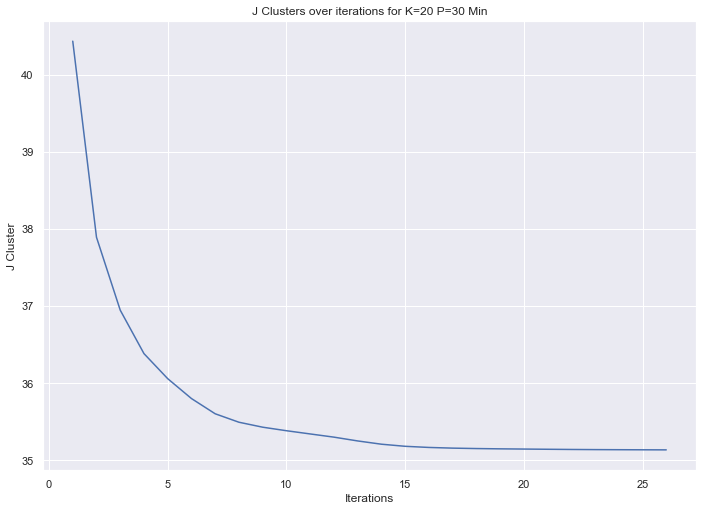

In [12]:
m_k.plotJCluster()

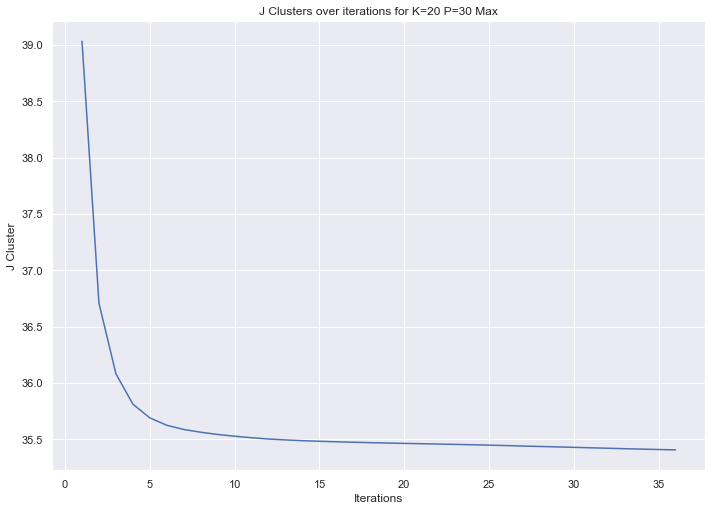

In [13]:
m_k.plotJCluster(False)

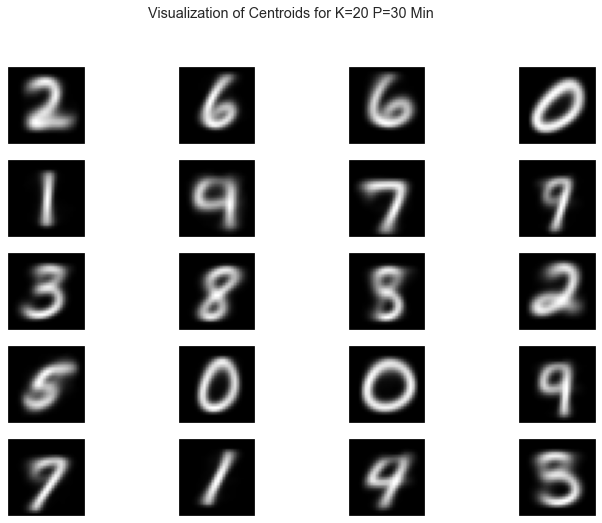

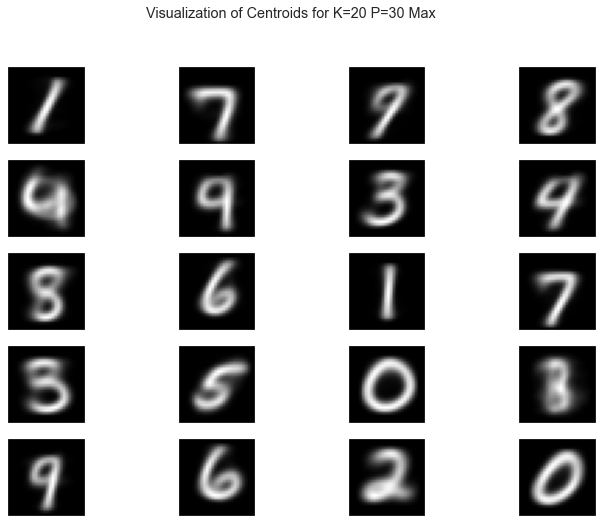

In [14]:
m_k.visualizeCentroids(5, 4)
m_k.visualizeCentroids(5, 4, False)

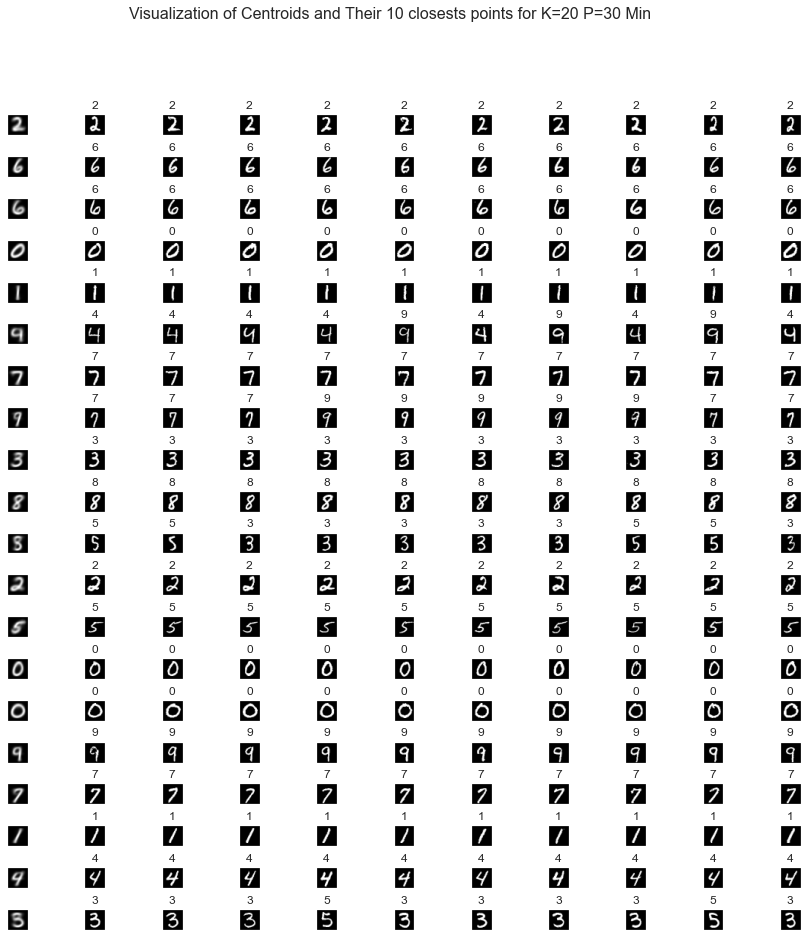

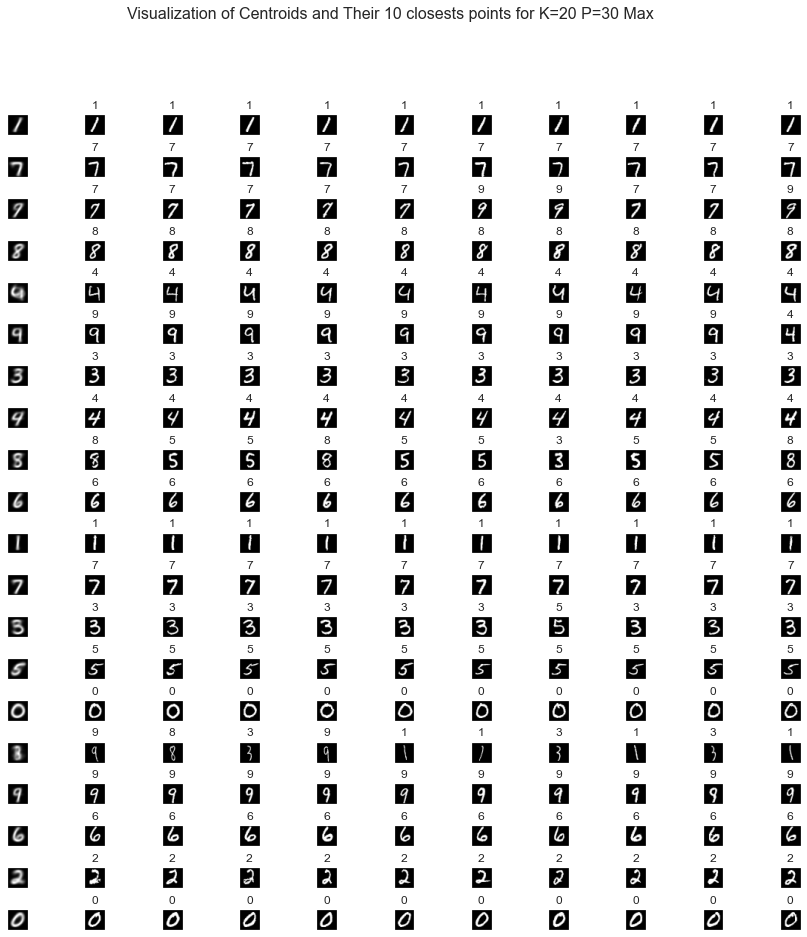

In [15]:
m_k.visualizeClosestToCentroids()
m_k.visualizeClosestToCentroids(False)

In [16]:
m_k_2 = K_means(X_train, y_train, 10, 20, 0.0001, random_seed = 42)
m_k_2.train()

Convergence has occurred. Iterating for 5 more loops
Run: 1 Iterations: 27 Time: 43.97245383262634
Convergence has occurred. Iterating for 5 more loops
Run: 2 Iterations: 35 Time: 55.29416823387146
Convergence has occurred. Iterating for 5 more loops
Run: 3 Iterations: 37 Time: 58.087645053863525
Convergence has occurred. Iterating for 5 more loops
Run: 4 Iterations: 17 Time: 27.640140056610107
Convergence has occurred. Iterating for 5 more loops
Run: 5 Iterations: 32 Time: 51.100977420806885
Convergence has occurred. Iterating for 5 more loops
Run: 6 Iterations: 24 Time: 37.64695596694946
Convergence has occurred. Iterating for 5 more loops
Run: 7 Iterations: 41 Time: 64.34171915054321
Convergence has occurred. Iterating for 5 more loops
Run: 8 Iterations: 27 Time: 42.590595960617065
Convergence has occurred. Iterating for 5 more loops
Run: 9 Iterations: 18 Time: 28.63263773918152
Convergence has occurred. Iterating for 5 more loops
Run: 10 Iterations: 23 Time: 36.4932599067688
Conver

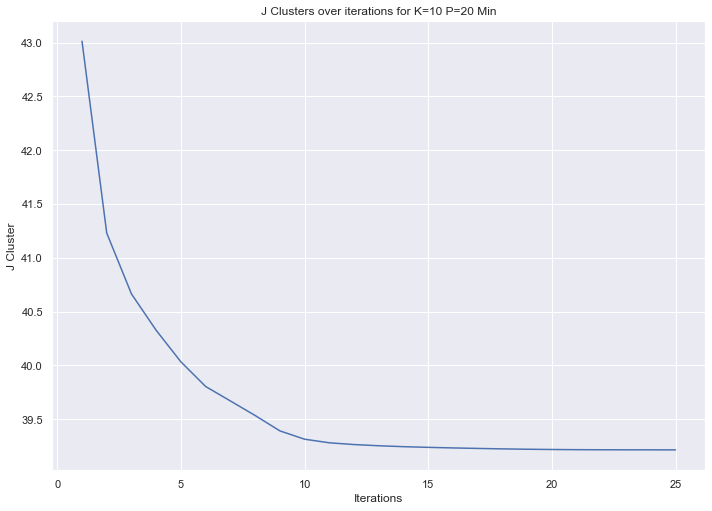

In [17]:
m_k_2.plotJCluster()


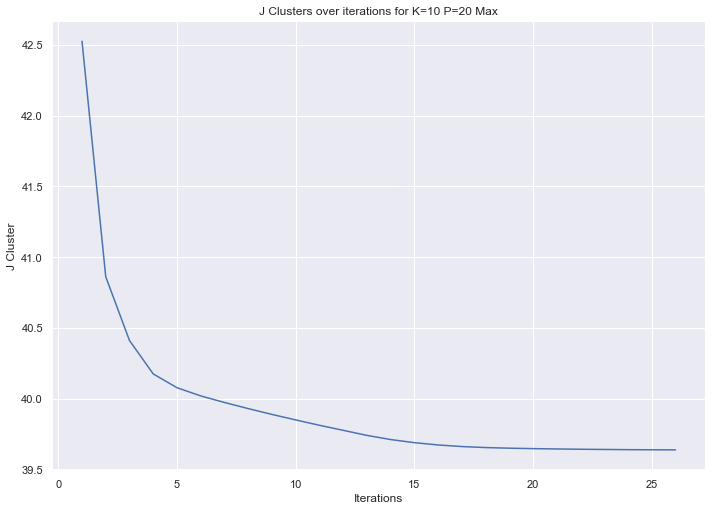

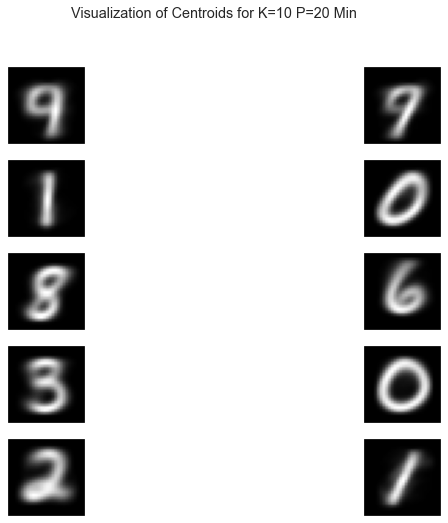

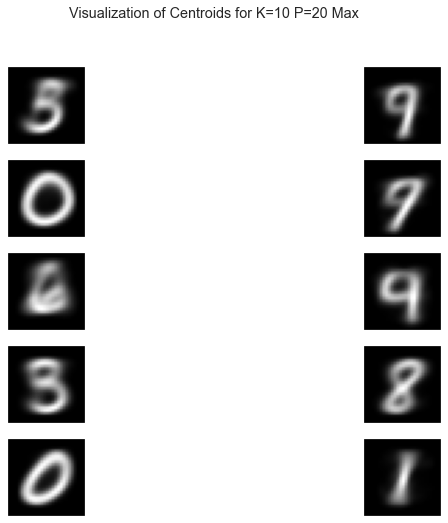

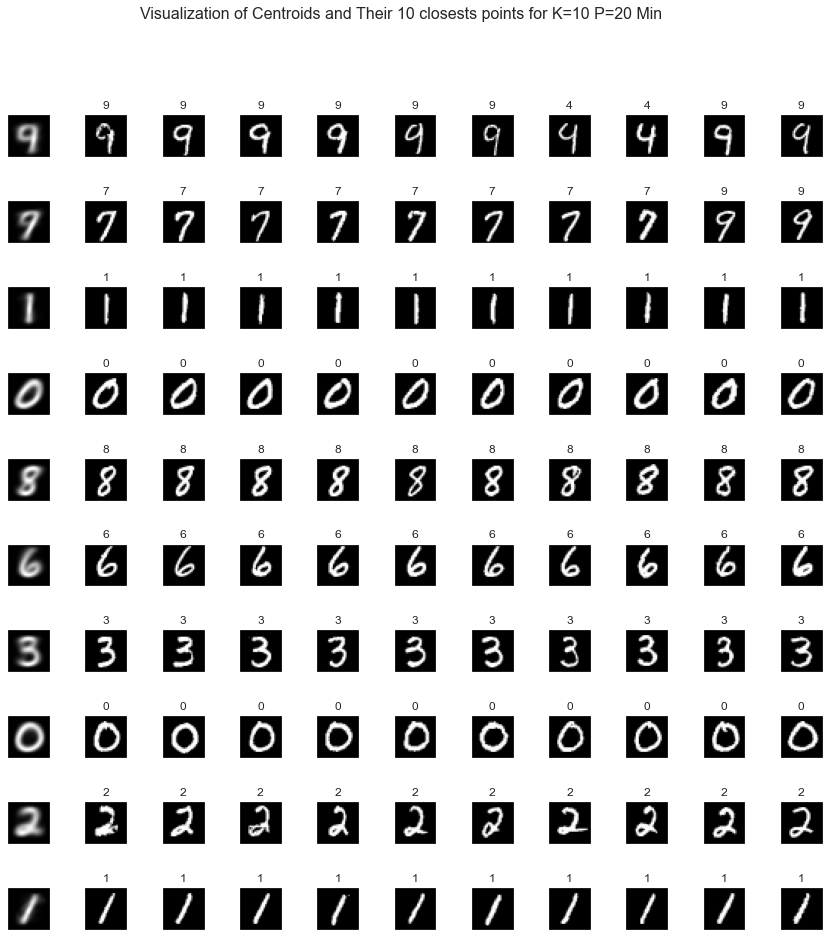

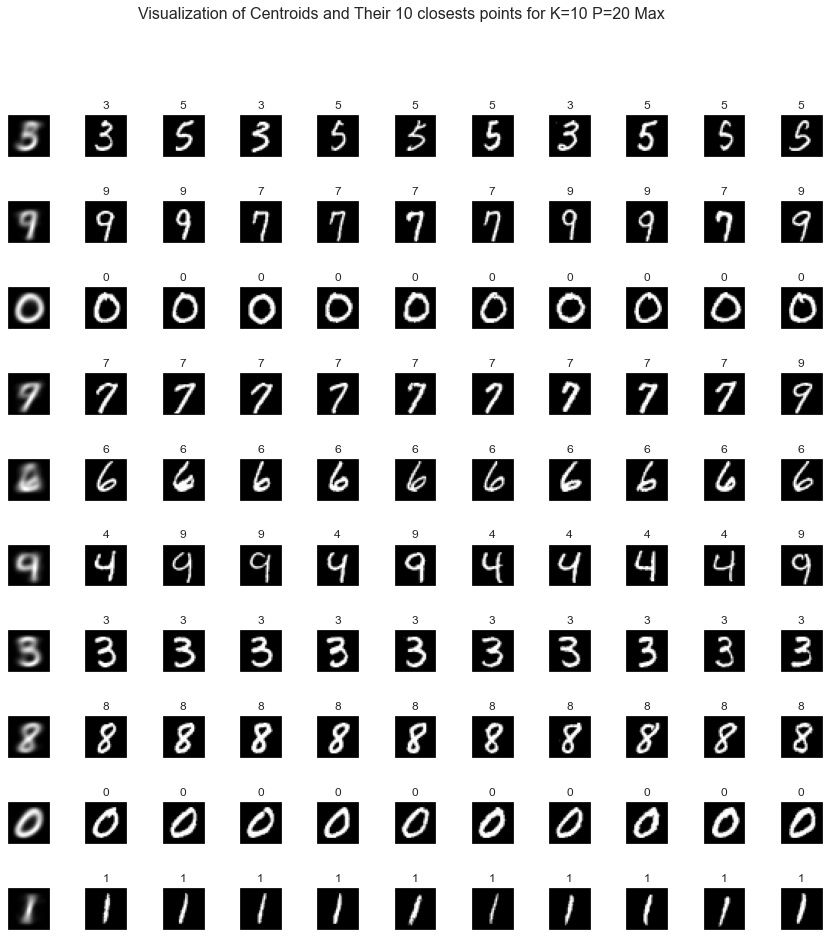

In [18]:
m_k_2.plotJCluster(False)
m_k_2.visualizeCentroids(5, 2)
m_k_2.visualizeCentroids(5, 2, False)
m_k_2.visualizeClosestToCentroids()
m_k_2.visualizeClosestToCentroids(False)

In [19]:
m_k_3 = K_means(X_train, y_train, 5, 10, 0.0001, random_seed = 42)
m_k_3.train()


Convergence has occurred. Iterating for 5 more loops
Run: 1 Iterations: 30 Time: 40.31097602844238
Convergence has occurred. Iterating for 5 more loops
Run: 2 Iterations: 38 Time: 50.41848087310791
Convergence has occurred. Iterating for 5 more loops
Run: 3 Iterations: 23 Time: 30.309616088867188
Convergence has occurred. Iterating for 5 more loops
Run: 4 Iterations: 25 Time: 33.48848533630371
Convergence has occurred. Iterating for 5 more loops
Run: 5 Iterations: 16 Time: 21.542802333831787
Convergence has occurred. Iterating for 5 more loops
Run: 6 Iterations: 36 Time: 47.51836347579956
Convergence has occurred. Iterating for 5 more loops
Run: 7 Iterations: 21 Time: 28.210541248321533
Convergence has occurred. Iterating for 5 more loops
Run: 8 Iterations: 43 Time: 56.6472589969635
Convergence has occurred. Iterating for 5 more loops
Run: 9 Iterations: 21 Time: 28.38364553451538
Convergence has occurred. Iterating for 5 more loops
Run: 10 Iterations: 26 Time: 34.42642259597778
Total T

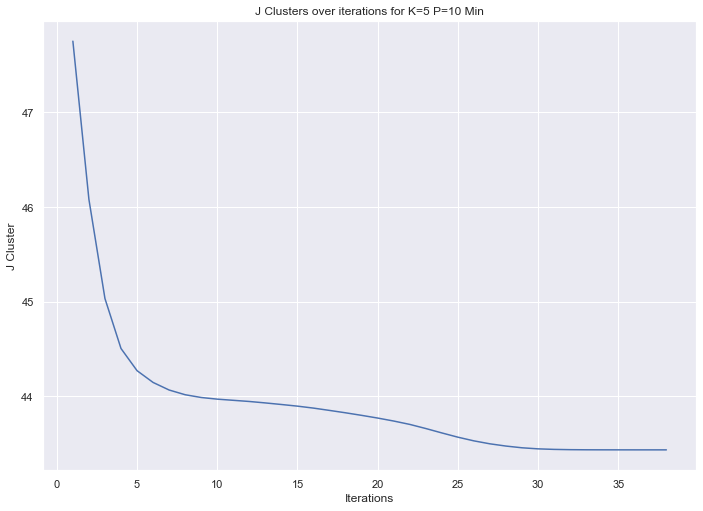

In [20]:
m_k_3.plotJCluster()

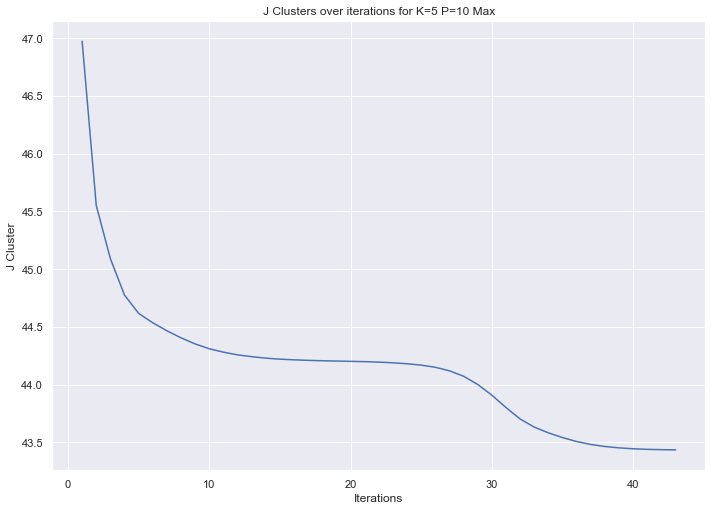

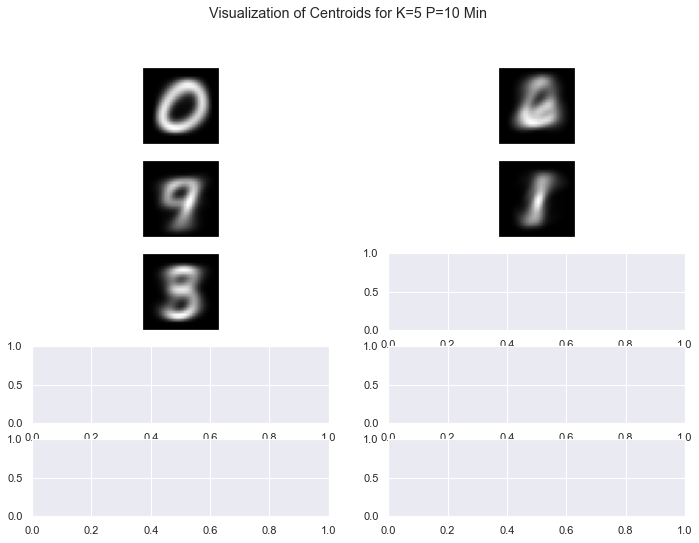

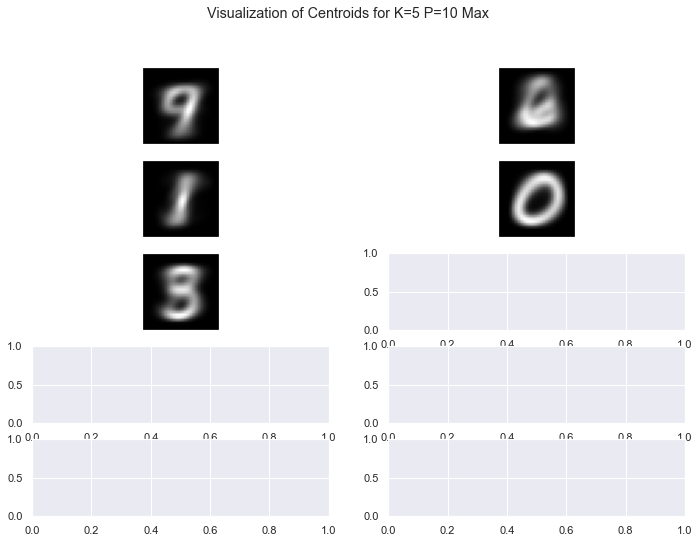

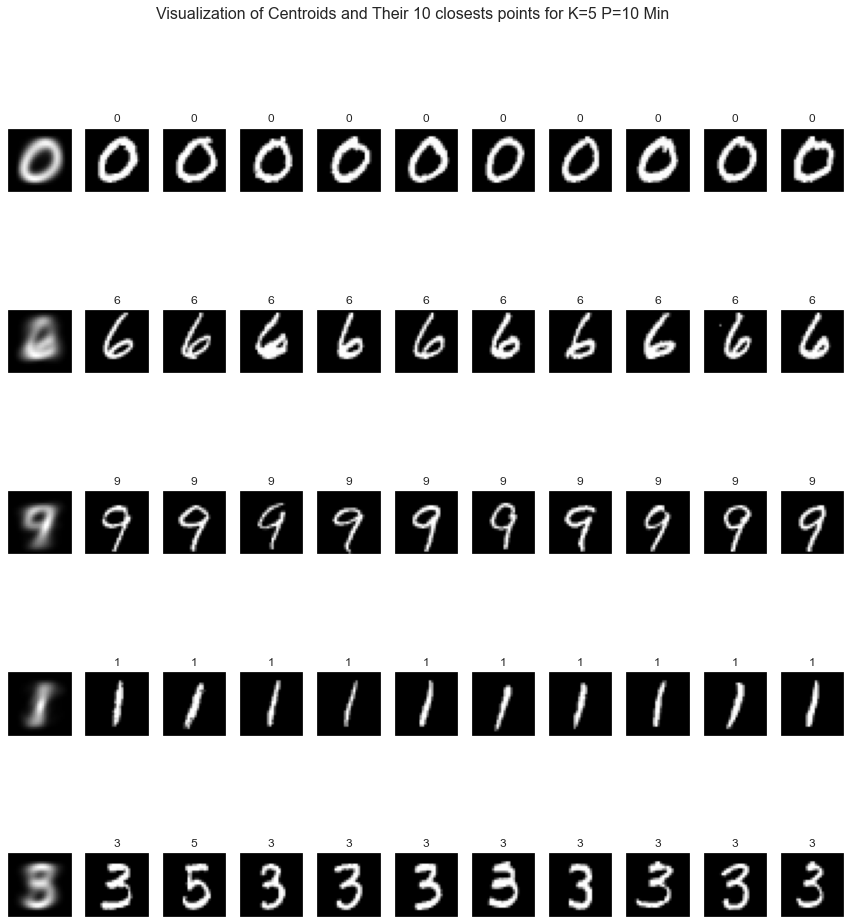

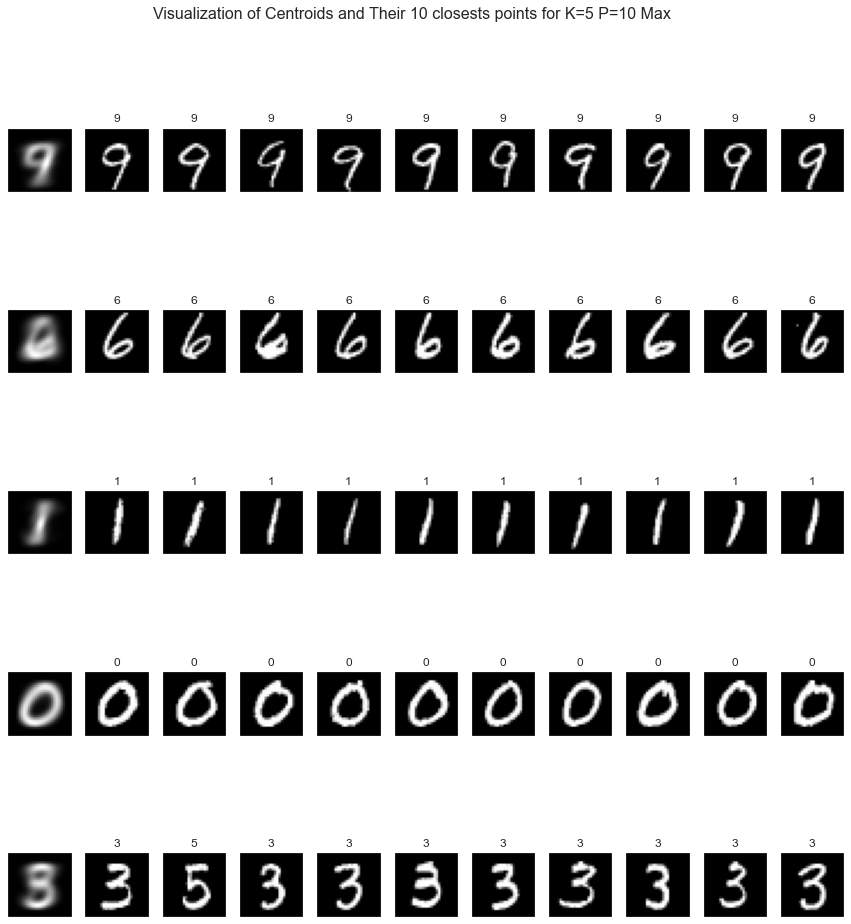

In [21]:
m_k_3.plotJCluster(False)
m_k_3.visualizeCentroids(5, 2)
m_k_3.visualizeCentroids(5, 2, False)
m_k_3.visualizeClosestToCentroids()
m_k_3.visualizeClosestToCentroids(False)

In [7]:
prediction = m_k.predict(X_test)
Binary_Classifier.errorRate(prediction, y_test)

0.3019

,0,1,2,3,4,5,6,7,8,9,10
0,906,1,0,9,3,39,18,1,3,0,980
1,0,1115,2,0,0,12,3,2,1,0,1135
2,20,44,830,17,19,40,12,22,26,2,1032
3,3,22,26,687,0,214,2,17,33,6,1010
4,1,21,0,0,509,43,26,110,0,272,982
5,16,9,3,296,16,457,17,28,39,11,892
6,23,8,4,2,14,37,864,5,0,1,958
7,1,49,10,1,33,6,0,876,4,48,1028
8,14,19,10,108,17,368,5,25,401,7,974
9,11,7,2,8,295,17,2,329,2,336,1009


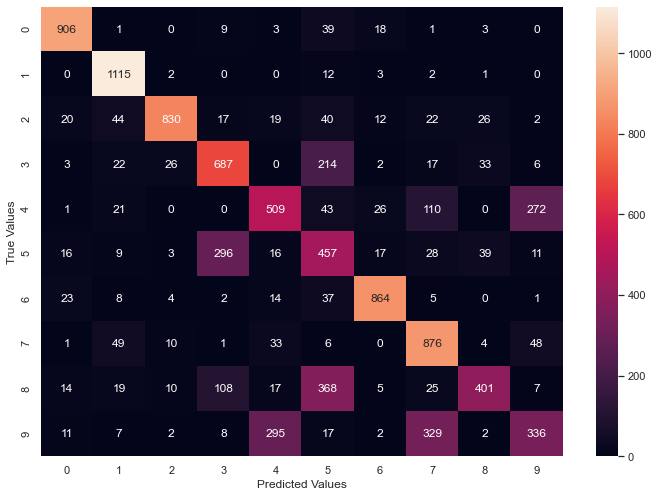

In [8]:
Binary_Classifier.confusion_matrix(prediction, y_test)